# Teacher Mobility and Retention

Queries reproducing numbers and tables from Ana Elfer's slides.

In [16]:
# Initialization: imports

import os
import os.path
import sys
# add to sys.path so python can find S275
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import pandas.io.sql as psql
import seaborn as sns

import S275

conn = S275.get_db_conn()

In [17]:
sql = """
With Counts as (
	SELECT
		st.AcademicYear,
		SUM(CASE WHEN Sex = 'M' THEN 1 ELSE 0 END) AS Male,
		SUM(CASE WHEN Sex = 'F' THEN 1 ELSE 0 END) AS Female,
		SUM(CASE WHEN HighestDegree = 'B' THEN 1 ELSE 0 END) AS EdBachelors,
		SUM(CASE WHEN HighestDegree = 'M' THEN 1 ELSE 0 END) AS EdMasters,
		SUM(CASE WHEN RaceEthOSPI = 'American Indian/Alaskan Native' THEN 1 ELSE 0 END) AS RaceAmInd,
		SUM(
			CASE WHEN RaceEthOSPI = 'Asian' THEN 1 ELSE 0 END +
			CASE WHEN RaceEthOSPI = 'Native Hawaiian/Other Pacific Islander' THEN 1 ELSE 0 END
		) AS RaceAsianPacIsl,
		SUM(CASE WHEN RaceEthOSPI = 'Black/African American' THEN 1 ELSE 0 END) AS RaceBlack,
		SUM(CASE WHEN RaceEthOSPI = 'Hispanic/Latino of any race(s)' THEN 1 ELSE 0 END) AS RaceHispanic,
		SUM(CASE WHEN RaceEthOSPI = 'Two or More Races' THEN 1 ELSE 0 END) AS RaceTwoOrMore,
		SUM(CASE WHEN RaceEthOSPI = 'White' THEN 1 ELSE 0 END) AS RaceWhite,
		SUM(CASE WHEN CertYearsOfExperience <= 4.5 THEN 1 ELSE 0 END) AS Exp0to4,
		SUM(CASE WHEN CertYearsOfExperience > 4.5 AND CertYearsOfExperience <= 14.5 THEN 1 ELSE 0 END) AS Exp5to14,
		SUM(CASE WHEN CertYearsOfExperience > 14.5 AND CertYearsOfExperience <= 24.5 THEN 1 ELSE 0 END) AS Exp15to24,
		SUM(CASE WHEN CertYearsOfExperience > 24.5 THEN 1 ELSE 0 END) AS ExpOver25,
		count(*) as TotalTeachers
	FROM Fact_SchoolTeacher st
	JOIN Dim_Staff s
		ON st.StaffID = s.StaffID
	WHERE PrimaryFlag = 1
	GROUP BY
		st.AcademicYear
)
select
	AcademicYear,
	TotalTeachers,
	CAST(Male AS REAL) / CAST(TotalTeachers AS REAL) AS PctMale,
	CAST(Female AS REAL) / CAST(TotalTeachers AS REAL) AS PctFemale,
	CAST(EdBachelors AS REAL) / CAST(TotalTeachers AS REAL) AS PctEdBachelors,
	CAST(EdMasters AS REAL) / CAST(TotalTeachers AS REAL) AS PctEdMasters,
	CAST(RaceAmInd AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctRaceAmInd,
	CAST(RaceAsianPacIsl AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctRaceAsianPacIsl,
	CAST(RaceBlack AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctRaceBlack,
	CAST(RaceHispanic AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctRaceHispanic,
	CAST(RaceTwoOrMore AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctRaceTwoOrMore,
	CAST(RaceWhite AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctRaceWhite,
	CAST(Exp0to4 AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctExp0to4,
	CAST(Exp5to14 AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctExp5to14,
	CAST(Exp15to24 AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctExp15to24,
	CAST(ExpOver25 AS REAL) / CAST(TotalTeachers AS REAL) * 100.0 AS PctExpOver25
FROM Counts
WHERE AcademicYear = 1996 OR AcademicYear = 2018
order by AcademicYear;
"""

df = psql.read_sql(sql, conn)

df

,AcademicYear,TotalTeachers,PctMale,PctFemale,PctEdBachelors,PctEdMasters,PctRaceAmInd,PctRaceAsianPacIsl,PctRaceBlack,PctRaceHispanic,PctRaceTwoOrMore,PctRaceWhite,PctExp0to4,PctExp5to14,PctExp15to24,PctExpOver25
0,1996,49036,0.320193,0.679807,0.426850,0.462884,0.756587,2.043397,1.613101,1.678359,0.0000,93.871849,20.466597,35.416836,30.498001,13.618567
1,2018,62970,0.261585,0.738367,0.319581,0.657408,0.724154,3.031602,1.324440,4.519612,1.5293,88.813721,25.513735,35.277115,25.023027,14.184533


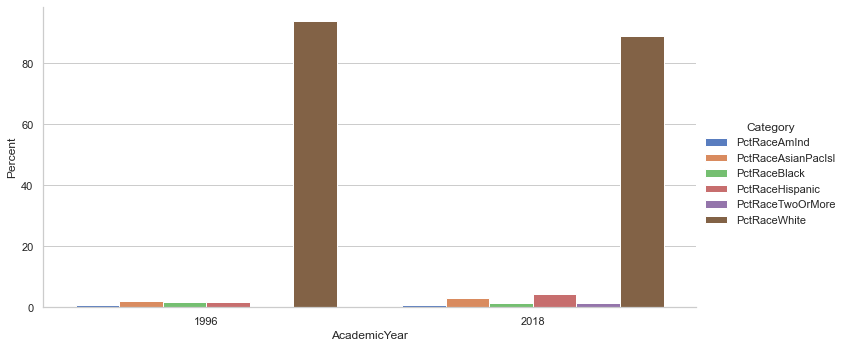

In [23]:
# transform into a long table
long = df.melt(
    id_vars=['AcademicYear', 'TotalTeachers'],
    value_vars=['PctRaceAmInd', 'PctRaceAsianPacIsl', 'PctRaceBlack', 'PctRaceHispanic', 'PctRaceTwoOrMore', 'PctRaceWhite'],
    var_name='Category', value_name='Pct')

# plot it
sns.set(style="whitegrid")

g = sns.catplot(
    x="AcademicYear",
    y="Pct",
    hue="Category",
    data=long,
    #height=6,
    aspect=2,
    kind="bar",
    palette="muted")
g.set_ylabels("Percent")
g;